# Capstone: Image Classification
## Classifying CT Scans of Lung Cancer 

In [1]:
# !pip install pydicom ## allows for reading of dicom data
# !pip install opencv-python ## image processing library
# !pip install pyyaml h5py ## checkpoint models
# !pip install matplotlib --upgrade
# !pip install seaborn

In [1]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# from google.colab import drive

# TensorFlow & Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Sklearn Imports
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
from skimage import transform

# Flask Imports
import json
import pickle
from flask import Flask, jsonify
from flask_restful import Api, Resource, reqparse

In [4]:
# drive.mount('/content/drive')

## Importing Data
- Several thousand images were aggregated from the following:
- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset
    - This dataset is used as a main source of non-cancerous ct scans. No COVID images were used only normal/healthy
- https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
    - Data used for ct scans that contain cancer, as well as a more non-cancerous ct scans.
- https://www.cancerimagingarchive.net/
    - The last of the cancer images, under 100 images were used from this dataset.

In [6]:
## Converting Dicom Images to JPG
## https://medium.com/@vivek8981/dicom-to-jpg-and-extract-all-patients-information-using-python-5e6dd1f1a07d
# import pydicom as dicom
# import os
# import cv2
# import PIL # optional
# # make it True if you want in PNG format
# PNG = False
# # Specify the .dcm folder path
# folder_path = "dicom/4.000000-NA-24533/"
# # Specify the output jpg/png folder path
# jpg_folder_path = "data/dicom_jpg"
# images_path = os.listdir(folder_path)
# for n, image in enumerate(images_path):
#     ds = dicom.dcmread(os.path.join(folder_path, image))
#     pixel_array_numpy = ds.pixel_array
#     if PNG == False:
#         image = image.replace('.dcm', '.jpg')
#     else:
#         image = image.replace('.dcm', '.png')
#     cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
#     if n % 50 == 0:
#         print('{} image converted'.format(n))

In [4]:
import zipfile
# with zipfile.ZipFile('archive.zip',"r") as zip_ref:
#     zip_ref.extractall("data")
# with zipfile.ZipFile('archive2.zip',"r") as zip_ref:
#     zip_ref.extractall("data_2")
# with zipfile.ZipFile('2d_images/2d_images.zip',"r") as zip_ref:
#    zip_ref.extractall("2d_Imgs")

In [2]:
# setting up paths
train_path = 'data/train/'
test_path = 'data/test/'
valid_path = 'data/valid/'

## Checking Images

In [3]:
def display_sample(data_path,img_class): # function to display images of desired data path

    path_class = ['cancer', 'non_cancer'] # class of each data set

    path_list = []

    # creating a dataframe out of train, valid, and test folders
    for index, sp in enumerate(path_class):
        for file in os.listdir(os.path.join(data_path, sp)):
            path_list.append([sp + "/" + file, index, sp])
    
    data_path_frame = pd.DataFrame(path_list, columns = ['File', 'ID','Class'])
    
    fig, ax = plt.subplots(3,3,figsize=(8,8))
    df_files = data_path_frame['File'][data_path_frame['Class'] == img_class].values
    
    n = 0
    fig.suptitle(img_class, fontsize = 14, color = "Black")
    for i in range(3):
        for j in range(3):
            image_path = os.path.join(data_path, df_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

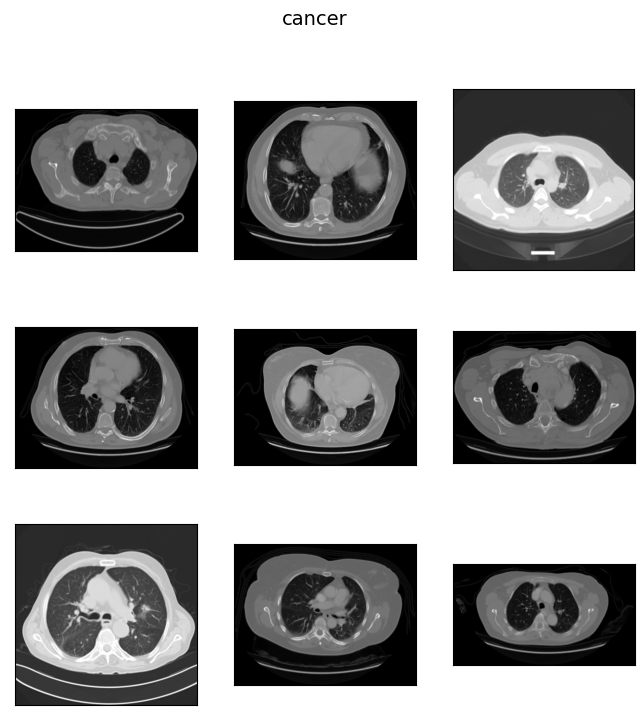

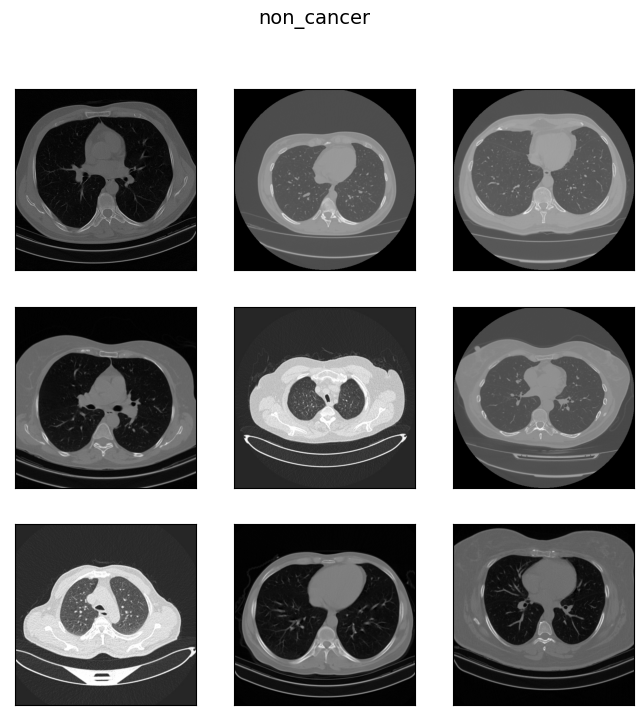

In [4]:
display_sample(valid_path,'cancer')
display_sample(train_path,'non_cancer')

## EDA and Modeling Overview:
- After an initial clean and quick review of the data I ran several models to see how they would perform. Upon performance review, I discovered severe overfitting from my data. After performing a misclassification analysis, I discovered that many images were duplicates despite having different file names. Additionally, I discovered I had several mis-labeled images that I had missed upon my first sweep of the data. After gathering more data, reviewing every image, and re-labeling my data, I ended with 2000 training images, 400 validation images and 80 testing images, split 50/50 respectively.

## Pre-Processing

In [5]:
# scaling data
train_gen = ImageDataGenerator(
    rescale=None, # no need to rescale as images are already scaled 0-1
    rotation_range=40, # range for random rotations
    width_shift_range=.1, # at random will shift width
    height_shift_range=.1, # at random will shift height
    zoom_range=.1, # range for random zooms
    horizontal_flip=False, # randomly flip horizontally
    vertical_flip=False # randomly flip vertically
    ) 

test_gen = ImageDataGenerator(rescale=None)


valid_gen = ImageDataGenerator(rescale=None)

In [6]:
# will use binary and grayscale for all images
train_data = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    color_mode='grayscale') 

valid_data = valid_gen.flow_from_directory(
    valid_path,
    class_mode='binary',
    color_mode='grayscale')
    
test_data = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False)
# setting suffle to False on test only 
# Test samples don’t get shuffled as to get consistent label assignment/alphanumeric 
# order as the validation classes

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [7]:
# Checking all sizes are the same
print(train_data.image_shape)
print(valid_data.image_shape)
print(test_data.image_shape)

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


In [8]:
train_data.class_indices # ensuring .gitignore is working and indcies contain no .checkpoints

{'cancer': 0, 'non_cancer': 1}

## Examining Distribution of Data and Establishing Baseline

In [9]:
def image_distribution(data):
    # getting array of images per class
    height = np.unique(data.classes,return_counts=True)[1]

    fig, ax = plt.subplots(figsize=(6,4))

    ax.bar(x=['Cancer','Non-Cancer'],height=height,
    width=.4,color=['thistle','lightblue'])

    plt.title('Number of Images in Training Data')
    plt.xlabel('Class')
    plt.ylabel('Image Count')
    plt.ylim(top=height[0]+60) # 60 above top to give annotations space
    plt.bar_label(ax.containers[0]);

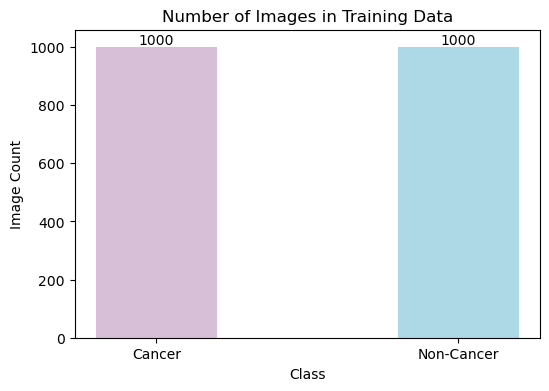

In [10]:
image_distribution(train_data)

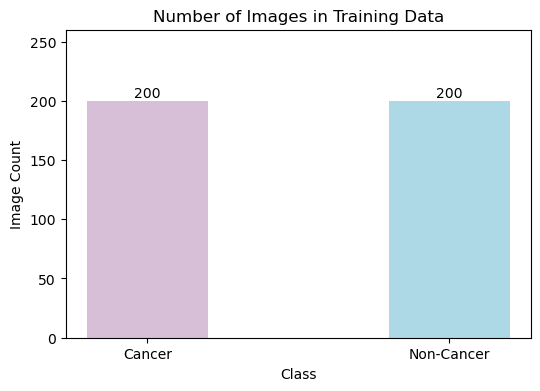

In [11]:
image_distribution(valid_data)

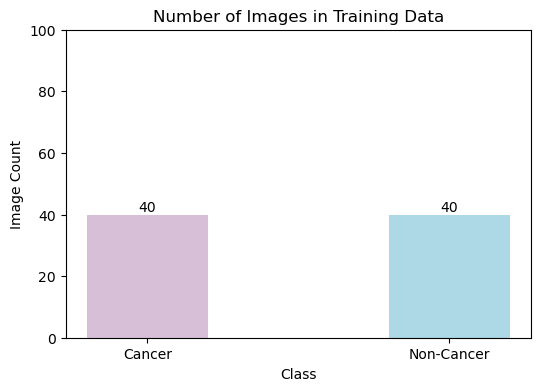

In [12]:
image_distribution(test_data)

## Modeling
- Initally I wanted to create a custom model that could compete with transfer learning models, however I was unsuccessful. After creating 15 models, my best model resulted in model 4. Despite attempts to keep the model simple while attempting a diverse range of regularization methods, the ResNet50 model would end up outperforming all of my models.
- Epochs and summarys removed for the sake of the space and length of the notebook. Notebook 2 contains epoch lists and model summaries.

## Model 4

In [24]:
# instantiating model
model4 = tf.keras.models.Sequential([
    # Input Layer
    # Greyscale input requires 1 channel alongside image size, filters at 16 to avoid overfitting
    tf.keras.layers.Conv2D(input_shape=(256,256,1),padding='same',filters=16,kernel_size=(3,3)),
    # attempting BatchNormalization prior to activation
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Hidden Layer
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Output Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')
])

In [25]:
opt = keras.optimizers.Adam(learning_rate=0.01)  # .001 is default

model4.compile(loss='binary_crossentropy', 
               optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0.03,
    verbose=1, 
    patience=10) 

In [24]:
history4 = model4.fit(
    train_data,
    batch_size=16,
    validation_data=valid_data,
    epochs=20,
    callbacks=[early_stop])

In [23]:
# model4.save("models/model4.h5")

## Model 4 Predictions and Results

In [13]:
model4 = load_model('models/model4.h5')

2022-10-13 10:50:48.162647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# creating function to return classification report, confusion matrix,
# misclassified images, and distribution of classified images
def model_results(model,data,path):
    y_pred = model.predict(data)
    predictions = []
    for each in y_pred:
        for num in each:
            if num <= .5:
                predictions.append(0)
            else:
                predictions.append(1)
    
    plt.hist(predictions)
    print(classification_report(data.classes,predictions))             
    c_matrix = confusion_matrix(data.classes,predictions)
    display = ConfusionMatrixDisplay(c_matrix).plot()
    plt.show()
    
    path_class = ['cancer', 'non_cancer']

    path_list = []

    for index, sp in enumerate(path_class):
        for file in os.listdir(os.path.join(path, sp)):
            path_list.append([sp + "/" + file, index, sp])
        
    misclass = pd.DataFrame(path_list, columns = ['File', 'Id','Class'])
    misclass['Predictions'] = predictions
    
    img_misclass = misclass['File'][misclass['Id']!=misclass['Predictions']].values
    img_misclass_type = misclass['Class'][misclass['Id']!=misclass['Predictions']].values
    
    opp = []
    for each in img_misclass_type:
        if each == 'cancer':
            opp.append('non_cancer')
        elif each == 'non_cancer':
            opp.append('cancer')
        
    subs = len(img_misclass)//2
    if subs > 1:
        fig, ax = plt.subplots(subs,subs,figsize=(8,8)) 
        n = 0
        for i in range(subs):
            for j in range(subs):
                image_path = os.path.join(path, img_misclass[n])
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                ax[i, j].set_xlabel(f'Actual Class: {img_misclass_type[n]} \nMisclassified as: {opp[n]}')
                ax[i, j].imshow(cv2.imread(image_path))
                n += 1
    elif subs < 2:
        n=0
        fig, ax = plt.subplots()
        image_path = os.path.join(path, img_misclass[n])
        ax.imshow(cv2.imread(image_path))
        ax.set_xlabel(f'Actual Class: {img_misclass_type[n]} \nMisclassified as: {opp[n]}')
        n+=1

3/3 [==============================] - 2s 401ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.97      0.93      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



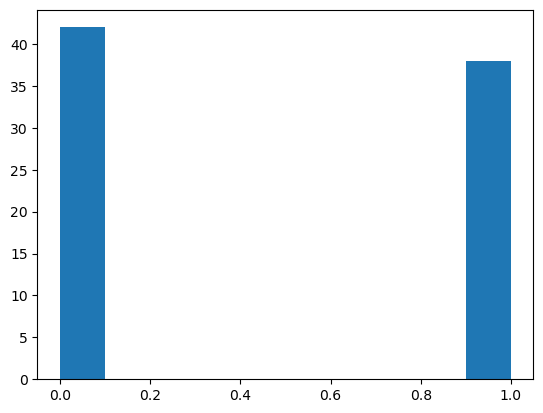

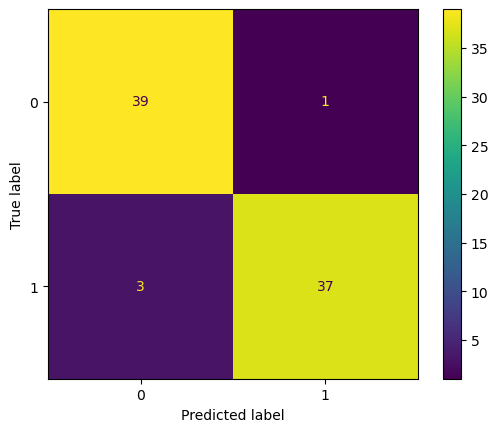

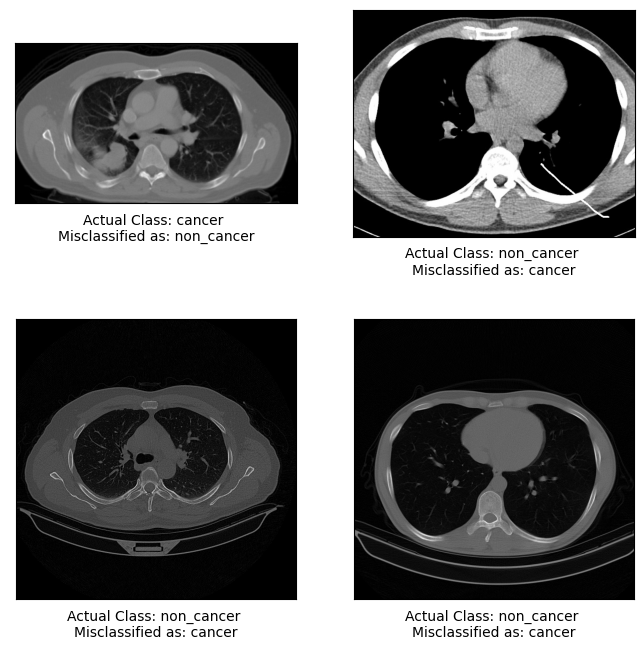

In [15]:
model_results(model4,test_data,test_path)

Model 4 takes extreme counteraction to any overfitting. With 16 filters, batch normalization before any activation followed by a dropout penalty of 30% in the networks hidden layer gives adequate results. Given this is medical data and we are optimizing for high precision and minimal false negatives, only one scan was classified as non-cancerous when it was actually cancerous. 3 scans were classified as cancer when they were in fact non-cancerous. While not ideal, it is better to tell someone they have cancer when they do not opposed to telling someone they do not have cancer when they do.

## Transfer Learning

### ResNet50

In [59]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(256,256,1))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Output
    output = Dense(1,activation = 'sigmoid')(x)
 

    # model
    model = Model(input,output)
    
    opt = tf.keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

In [25]:
res_model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint_filepath = '/content/drive/MyDrive/Capstone/model_checkpoints/ResNet50_Model.hdf5/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_best_only=True)

res_history = res_model.fit(
train_data,
batch_size=32,
validation_data=valid_data,
epochs=20,
callbacks=[annealer,model_checkpoint_callback])

In [16]:
resnet_model = load_model('transfer_models/resnet_model/')

3/3 [==============================] - 12s 3s/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



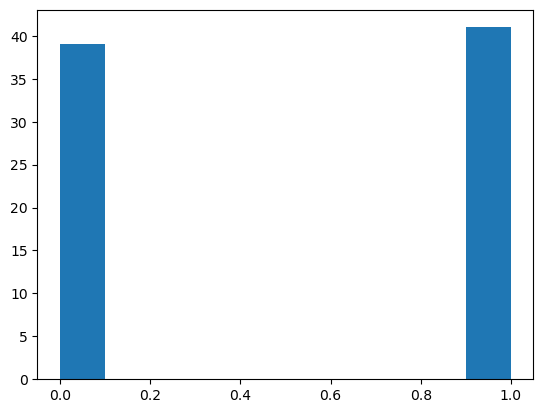

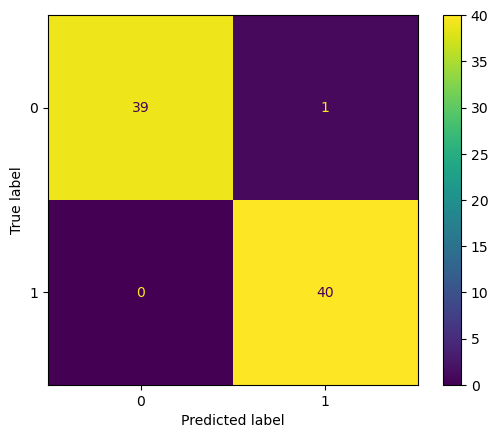

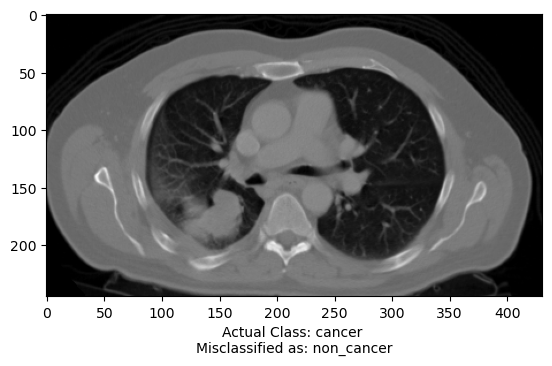

In [129]:
model_results(resnet_model,test_data,test_path)

In [ ]:
# model4.save("models/model4.h5")

In [130]:
resnet_model.save("transfer_models/ResNet50_model.h5")

In [62]:
# res_model.save('/content/drive/MyDrive/Capstone/models/resnet_model')

Using the ResNet50 model will be ideal as ResNet50 operates well with grayscale images. While misclassifying the same image as my custom model, no other images were misclassified.

### VGG16

In [14]:
# VGG16 requies 3 channels, changing color_mode to rgb
train_data = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    color_mode='rgb') 

valid_data = valid_gen.flow_from_directory(
    valid_path,
    class_mode='binary',
    color_mode='rgb')
    
test_data = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [48]:
def build_vgg116():
    
    VGG = VGG16(weights='imagenet', include_top = False)
    
    input = Input(shape=(256, 256, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = VGG(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    output = Dense(1,activation = 'sigmoid')(x)
 

    # model
    model = Model(input,output)
   
    
    opt = tf.keras.optimizers.Adam(learning_rate= 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics = ['accuracy'])
    model.summary()
    
    return model

In [26]:
vgg16_model = build_vgg116()

checkpoint_filepath = 'model_checkpoints/mobilenet.hdf5/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_best_only=True)

vgg_history = vgg16_model.fit(
train_data,
batch_size=32,
validation_data=valid_data,
epochs=30,
callbacks=[annealer,model_checkpoint_callback])

In [15]:
vgg16_model = load_model('transfer_models/vgg16_model/')

3/3 [==============================] - 28s 8s/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



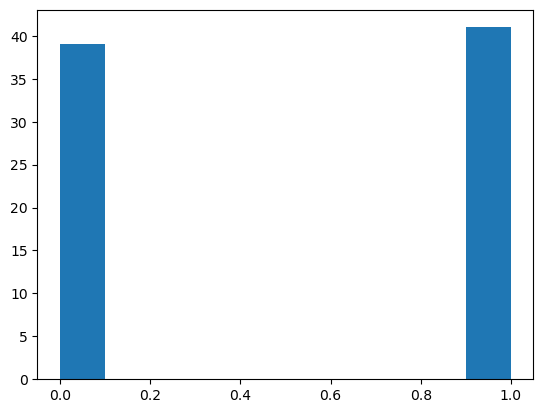

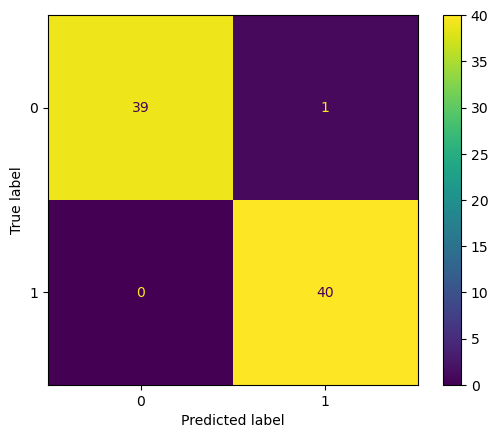

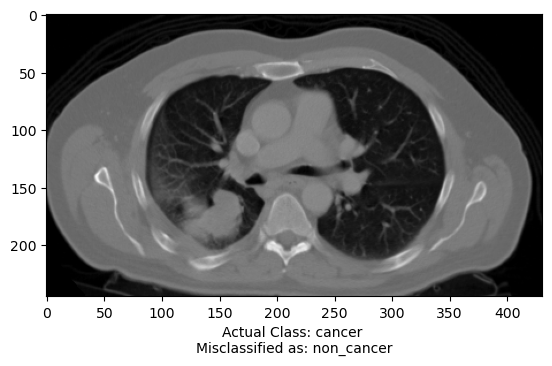

In [16]:
model_results(vgg16_model,test_data,test_path)

In [112]:
# vgg16_model.save('/content/drive/MyDrive/Capstone/models/vgg16_model')

While performing similarly to the ResNet50 model, VGG16 does not accept a channel of 1. I had to change the number of channels to 3 by changing the data color mode previously from 'grayscale' to 'rgb'. Performance may be the same but I'd rather use ResNet50 as these are grayscale images

### MobileNet

In [55]:
def build_mobilenet():
    mobile = MobileNetV2(weights='imagenet', include_top=False)

    input = Input(shape=(256, 256, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = mobile(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(1,activation = 'sigmoid')(x)
 

    # model
    model = Model(input,output)
    
    opt = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

In [27]:
mobilenet_model = build_mobilenet()

checkpoint_filepath = 'model_checkpoints/mobilenet.hdf5/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_best_only=True)

mobil_history = mobilenet_model.fit(
train_data,
batch_size=32,
validation_data=valid_data,
epochs=30,
callbacks=[annealer,model_checkpoint_callback])

In [17]:
mobilenet_model = load_model('transfer_models/mobilenet_model/')

3/3 [==============================] - 4s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        40
           1       0.89      1.00      0.94        40

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



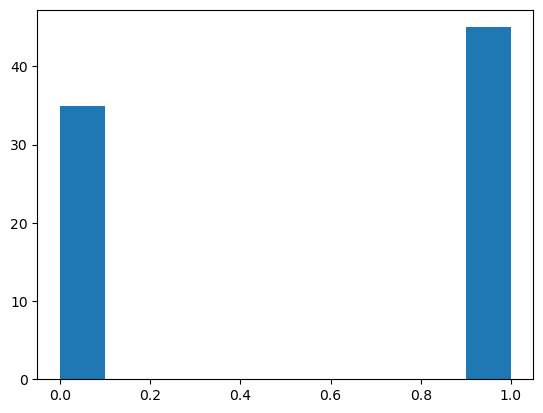

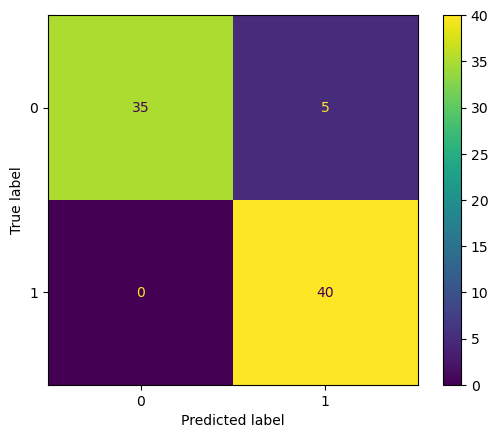

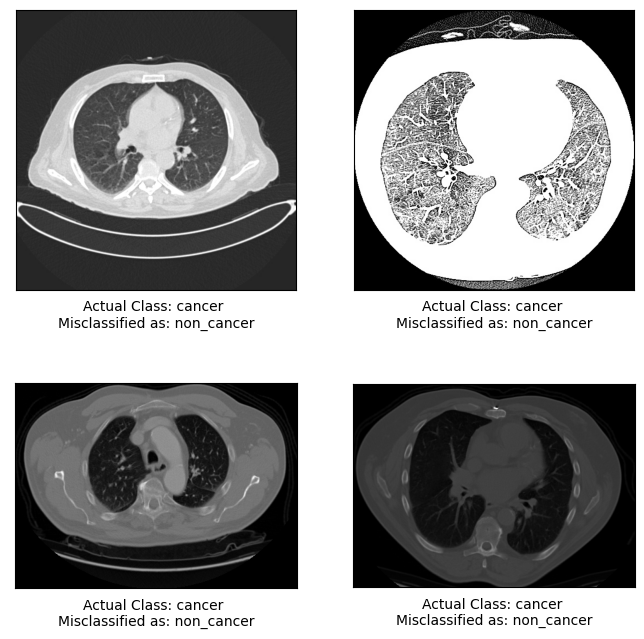

In [18]:
model_results(mobilenet_model,test_data,test_path)

In [113]:
# mobilenet_model.save('/content/drive/MyDrive/Capstone/models/mobilenet_model')

MobileNet did a poor job optimizing false negatives opposed to ResNet50, VGG16 and even my custom model. Additionally, MobileNet only allows for 3 channels as well so the same changes that were made to VGG16 were made here. This model will not be used.

In [126]:
def predict_any_image(filename):
    # load and transform image
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image, (256, 256, 1))
    np_image = np.expand_dims(np_image, axis=0)
    
    prediction = resnet_model.predict(np_image)
    plt.imshow(cv2.imread(filename))
    if prediction <=.5:
        plt.xlabel('The Model Predicts This Image Displays Cancer')
    else:
        plt.xlabel('The Model Predicts This Image Does Not Display Cancer')

1/1 [==============================] - 0s 229ms/step


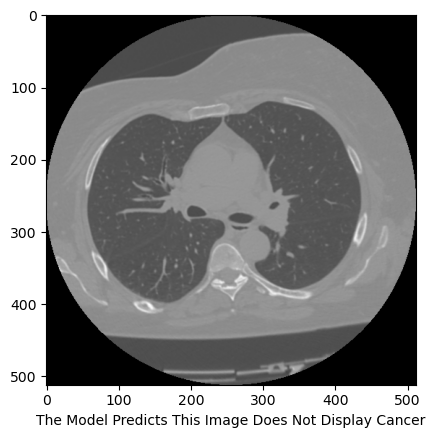

In [127]:
#predict_any_image('data/test/cancer/000108 (7).png')
predict_any_image('data/test/non_cancer/16_Morozov_study_0150_29.png')

1/1 [==============================] - 0s 240ms/step


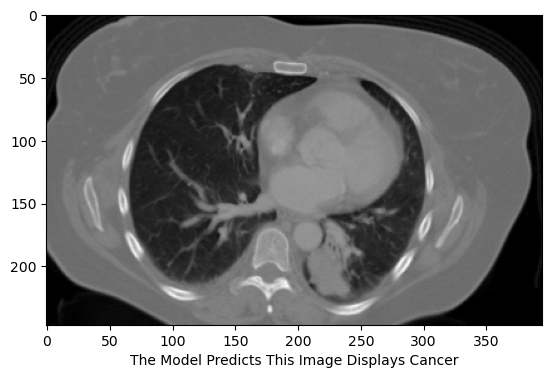

In [128]:
predict_any_image('data/test/cancer/000108 (8).png')

## Rest of Project is on aws and implementing streamlit

In [261]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Set figure size
    plt.figure(figsize=(8, 5))

    # Generate line plot of training, testing loss over epochs
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Categorical Crossentropy', fontsize = 18)
    plt.xticks(np.arange(10), np.arange(10))

    plt.legend(fontsize = 18);